# 增加 feature 后手动 xgbm 模型

### 之前 TPOT 其实输出的是 gradient descent regressor, 并不是 xgbm，
### TPOT 中的 gradient descent regressor 计算速度慢很多，所以可能没有最优化模型
### 这里将重心转移到特征工程上来，而不是模型选择。综合下面的原因，决定增加feature

- 在下面的 notebook 中，我们测试了 xgboost 得到的模型，在测试集上的得分为0.128 https://github.com/lidatou1991/udacity_final_rossmann/blob/master/GCP/XG-TPOT-GCP-2h-test.ipynb

- 还要继续提升模型得分的话，还有特征工程以及模型调整参数两条路径。在简单的调整模型参数数，发现分数提高不大 

- 我们发现，在没有做任何调参的 DT 以及 Adaboost 模型中，得分都还不错。说明肯定是在特征工程中导致了差异。
https://github.com/lidatou1991/udacity_final_rossmann/blob/master/DT-model.ipynb

- 通过对比，我们发现是在 'Date' 特征的处理上差异较大。 xgboost 中最先是 drop 掉了 'Date'

- 然后，阅读其他人的文章，发现其实这一特征非常重要。得分较好的队伍，甚至在 'Date' 基础上增加了很多 time bucket 特征

1. https://solgirouard.github.io/Rossmann_CS109A/
2.https://www.kaggle.com/c/rossmann-store-sales/discussion/18024



In [1]:
# 导入xgbm
import xgboost as xgb
import os
from time import time

In [2]:
#import multiprocessing
#multiprocessing.set_start_method('forkserver')

In [3]:
# Install tpot on the server
#!pip install tpot

In [4]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import operator
import matplotlib
import matplotlib.pyplot as plt

# Import the tpot regressor
#from tpot import TPOTRegressor

# Problem Description

- The task is a supervised regression problem: given sales data of Rossmann - a German chain drug store , I want to build a model that can predict the furture sales of Rossmann for the next 6 weeks. 

- Before I switch to the automated machine learning method, I have tried some complete machine learning model such as decision tree and Adaboost totally by hand. That is , the data cleaning, feature engineering, model selection and parameters tuning (although have not done yet for decision tree and adboost ) are done manualy

## Dataset

- Colab is able to retrieve data from GitHub directely

- store, train and test data sets are given but features and lables need to be splitted

- **Pay attention that test.csv does not include** ***Customers***

In [5]:
# read data from GitHub

train = pd.read_csv('inputs/train.csv')
test = pd.read_csv('inputs/test.csv')
store = pd.read_csv('inputs/store.csv')

print('Training data shape: ', train.shape)
print('testing data shape: ', test.shape)
print('Store data shape: ', store.shape)

/Users/limao/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Training data shape:  (1017209, 9)
testing data shape:  (41088, 8)
Store data shape:  (1115, 10)


## 数据清洗

- 这一步先进行简单的数据清洗，首先去除训练数据中的 Sales = 0 的数据

- 其次，对数据中的 NaN 进行补全

In [6]:
#train中去除open=1但是sales=0的数据

train = train.loc[train['Sales']>0]

print('{} train datas were deleted'.format(1017209 - len(train)))

172871 train datas were deleted


In [7]:
#train 中StateHoliday 将字符与数字0混淆，存在5个不同值

train.StateHoliday = train.StateHoliday.map({'0':'0',0:'0','a':'a','b':'b','c':'c'})

print('StateHoliday unique values {}'.format(len(train.StateHoliday.unique())))

StateHoliday unique values 4


In [8]:
#store 中 CompetitionDistance 的NaN用0填充
#store 中 CompetitionSince[X] 的NaN用1900-01填充

store.loc[store["CompetitionDistance"].isnull(),"CompetitionDistance"] = 0

store.loc[(store["CompetitionDistance"] != 0) & (store["CompetitionOpenSinceYear"].isnull()),"CompetitionOpenSinceYear"] = 1900
store.loc[(store["CompetitionDistance"] != 0) & (store["CompetitionOpenSinceMonth"].isnull()),"CompetitionOpenSinceMonth"] = 1

store.fillna(0,inplace = True)

In [9]:
#test中的NaN用1填充,因为其中的NaN 全部是 Open，如果Open=0 则没有预测的必要了

test.fillna(1,inplace = True)

In [10]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


# 特征工程

- 根据 Featuretools 中的经验，增加每个商店的平均顾客/销量特征，对模型表现提高很大

- 其次，增加单一商店在每个 weekday 销量的平均数据，对模型提升也很大。即使gradient descent 模型完全未调整参数也得分0.14

- 本项目实际上还可以看为时序序列预测，有理由相信，增加需预测时间段前一定时期的平均值，类似于平滑过渡，也可能有提升

## 首先处理时间特征 Date

### 将 Date 中的 年/月/日分离
- 在之前的考虑中，犯下了错误，将 Date 舍去。其实很明显可以看到 sales 与所处的年份/月份关系还是很大、
- 画出一个月内的每天平均销量变化图后，会发现一个月内波动也很大，因此与处于一个月哪一天也是有关系的。


In [11]:
#处理 train 中的日期
train.Date = pd.to_datetime(train.Date)#将日期数据转换为时间类型
train['year'] = train.Date.map(lambda x:x.year)
train['month'] = train.Date.map(lambda x:x.month)
train['day'] = train.Date.map(lambda x:x.day)

train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31


   ### 增加 DayOfYear/WeekOfYear
   
   - 参考 https://solgirouard.github.io/Rossmann_CS109A/notebooks/feature_engineering.html

In [12]:
#增加属于一年的第几天、第几周
train['dayofyear'] = train['Date'].dt.dayofyear

train['weekofyear'] = train['Date'].dt.weekofyear

train.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,dayofyear,weekofyear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,212,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,212,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,212,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,212,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,212,31


### 单一商店的平均顾客数、平均顾客数以及单客消费

In [13]:
## 首先将 sales 取对数
train['Sales'] = np.log1p(train['Sales'])

In [14]:
# 单客消费
train['SalesPerCustomer'] = train['Sales']/train['Customers']

In [15]:
# 单店的平均值
store_avg = train.groupby('Store')[['Sales','Customers','SalesPerCustomer']].mean()
store_avg.columns = ['AvgSales','AvgCustomers','AvgSalesPerCustomer']
store_avg.head()

,AvgSales,AvgCustomers,AvgSalesPerCustomer
Store,,,
1,8.446708,564.049936,0.015297
2,8.453979,583.998724,0.015511
3,8.795941,750.077022,0.012318
4,9.154714,1321.752551,0.007053
5,8.369616,537.340180,0.017699


In [16]:
# 添加在 store 后
store = pd.merge(store,store_avg,on ='Store',how = 'left')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,AvgSales,AvgCustomers,AvgSalesPerCustomer
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",8.453979,583.998724,0.015511
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",8.795941,750.077022,0.012318
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,9.154714,1321.752551,0.007053
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,8.369616,537.340180,0.017699


### 单一商店在每个 weekday 的销售量平均值

In [17]:
#例如 1号商店在周 2 的销售平均值为5177，因为可能顾客的购买行为会呈现出一定的周期性
# 2号商店在周5的销售平均值为4669
store_avg_weekday = train.groupby(['Store', 'DayOfWeek'],as_index=False)['Sales'].mean()
store_avg_weekday.columns = ['Store','DayOfWeek','AvgPerDay']
store_avg_weekday.head(12)

,Store,DayOfWeek,AvgPerDay
0,1,1,8.525573
1,1,2,8.428742
2,1,3,8.404854
3,1,4,8.382763
4,1,5,8.444185
5,1,6,8.492174
6,2,1,8.662412
7,2,2,8.550080
8,2,3,8.650497
9,2,4,8.491458


In [18]:
#上面的数据可以看到，非常有可能 DayOfWeek =7 的值都不存在，所以看 DayOfWeek 的 unique 值
store_avg_weekday['DayOfWeek'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [19]:
# 可以看到 星期天（DayOfWeek =7）数据对于部分商店是存在的，那么我们看总共有多少行
# 实际缺少的行数就为 1115*7 -6723 =1082，也就是还有1082种组合在train中无法计算
len(store_avg_weekday['DayOfWeek'])

6723

### 单一商店预测时间段前最后一周的平均销量

In [20]:
#猜测销量应该平滑过渡,最后七天的平均销量
#首先将数据按照日期由远到近排序

train.Date = pd.to_datetime(train.Date)

train.sort_values(by=['Date'], inplace=True, ascending= True)# 按照时间升序排序

train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,dayofyear,weekofyear,SalesPerCustomer
1017190,1097,2,2013-01-01,8.693161,1405,1,0,a,1,2013,1,1,1,1,0.006187
1016179,85,2,2013-01-01,8.347827,619,1,0,a,1,2013,1,1,1,1,0.013486
1016353,259,2,2013-01-01,8.832296,1444,1,0,a,1,2013,1,1,1,1,0.006117
1016356,262,2,2013-01-01,9.756610,2875,1,0,a,1,2013,1,1,1,1,0.003394
1016368,274,2,2013-01-01,8.040125,729,1,0,a,1,2013,1,1,1,1,0.011029


In [21]:
last_week = train.groupby(['Store'],as_index = False).tail(7)

last_week.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,dayofyear,weekofyear,SalesPerCustomer
31511,292,5,2015-07-03,8.524566,517,1,1,0,0,2015,7,3,184,27,0.016489
30396,292,6,2015-07-04,7.406711,184,1,0,0,0,2015,7,4,185,27,0.040254
28166,292,1,2015-07-06,8.230844,440,1,0,0,0,2015,7,6,187,28,0.018706
27051,292,2,2015-07-07,8.032035,370,1,0,0,0,2015,7,7,188,28,0.021708
25936,292,3,2015-07-08,7.786136,318,1,0,0,0,2015,7,8,189,28,0.024485


In [22]:
len(last_week.Store)

7805

In [23]:
store_last_week = last_week.groupby(['Store'],as_index = False)['Sales'].mean()
store_last_week.columns = ['Store','LastWeekSales']
store_last_week.head()

,Store,LastWeekSales
0,1,8.485476
1,2,8.518331
2,3,8.850395
3,4,9.262433
4,5,8.444093


### 构造出添加了新 feature 的 store 数据集

In [24]:
# 最后一周平均销量 先与 每个weekday 平均销量合并
store_new = pd.merge(store_last_week,store_avg_weekday,on = 'Store')
store_new.head()

,Store,LastWeekSales,DayOfWeek,AvgPerDay
0,1,8.485476,1,8.525573
1,1,8.485476,2,8.428742
2,1,8.485476,3,8.404854
3,1,8.485476,4,8.382763
4,1,8.485476,5,8.444185


In [25]:
store_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6723 entries, 0 to 6722
Data columns (total 4 columns):
Store            6723 non-null int64
LastWeekSales    6723 non-null float64
DayOfWeek        6723 non-null int64
AvgPerDay        6723 non-null float64
dtypes: float64(2), int64(2)
memory usage: 262.6 KB


In [26]:
# 单一商店的平均值再与之合并
store_new = pd.merge(store_new,store,on=['Store'],how = 'left')
store_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6723 entries, 0 to 6722
Data columns (total 16 columns):
Store                        6723 non-null int64
LastWeekSales                6723 non-null float64
DayOfWeek                    6723 non-null int64
AvgPerDay                    6723 non-null float64
StoreType                    6723 non-null object
Assortment                   6723 non-null object
CompetitionDistance          6723 non-null float64
CompetitionOpenSinceMonth    6723 non-null float64
CompetitionOpenSinceYear     6723 non-null float64
Promo2                       6723 non-null int64
Promo2SinceWeek              6723 non-null float64
Promo2SinceYear              6723 non-null float64
PromoInterval                6723 non-null object
AvgSales                     6723 non-null float64
AvgCustomers                 6723 non-null float64
AvgSalesPerCustomer          6723 non-null float64
dtypes: float64(10), int64(3), object(3)
memory usage: 892.9+ KB


In [27]:
#查看准备好的 store_new 数据样例
store_new.head()

,Store,LastWeekSales,DayOfWeek,AvgPerDay,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,AvgSales,AvgCustomers,AvgSalesPerCustomer
0,1,8.485476,1,8.525573,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
1,1,8.485476,2,8.428742,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
2,1,8.485476,3,8.404854,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
3,1,8.485476,4,8.382763,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
4,1,8.485476,5,8.444185,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297


In [28]:
#store_new = store_new.reindex(columns = ['Store','DayOfWeek','AvgPerDay','LastWeekSales'])
#store_new.head()

## 将 train 与 store_new 合并

In [29]:
train_new = pd.merge(train,store_new,on = ['Store','DayOfWeek'],how = 'left')
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 29 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null datetime64[ns]
Sales                        844338 non-null float64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
year                         844338 non-null int64
month                        844338 non-null int64
day                          844338 non-null int64
dayofyear                    844338 non-null int64
weekofyear                   844338 non-null int64
SalesPerCustomer             844338 non-null float64
LastWeekSales                844338 non-null float64
AvgPerDay                    844338 non-null float64
Stor

In [30]:
train_new.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,AvgSales,AvgCustomers,AvgSalesPerCustomer
0,1097,2,2013-01-01,8.693161,1405,1,0,a,1,2013,...,720.0,3.0,2002.0,0,0.0,0.0,0,9.165873,2420.921444,0.003857
1,85,2,2013-01-01,8.347827,619,1,0,a,1,2013,...,1870.0,10.0,2011.0,0,0.0,0.0,0,8.850326,1015.401274,0.009199
2,259,2,2013-01-01,8.832296,1444,1,0,a,1,2013,...,210.0,1.0,1900.0,0,0.0,0.0,0,9.340593,2374.844253,0.004029
3,262,2,2013-01-01,9.756610,2875,1,0,a,1,2013,...,1180.0,5.0,2013.0,0,0.0,0.0,0,9.916616,3402.010616,0.002981
4,274,2,2013-01-01,8.040125,729,1,0,a,1,2013,...,3640.0,1.0,1900.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct",8.261003,992.741416,0.008726


## 在 store 中增加考虑竞争时长的 feature
- 其实在 adaboost 模型中就有考虑过，效果还不错
https://github.com/lidatou1991/udacity_final_rossmann/blob/master/Adaboost.ipynb

### 单一商店竞争者存在的月份数

In [31]:
train_new['CompetitionExistMonth'] = 12 * (train_new['year']-train_new['CompetitionOpenSinceYear']) +\
(train_new['month']-train_new['CompetitionOpenSinceMonth'])
    
#不存在竞争的，对应竞争存在月份当然置于0
train_new.loc[train_new['CompetitionOpenSinceYear'] == 0, 'CompetitionExistMonth'] =0

### 单一商店竞争者存在的年数

In [32]:
train_new['CompetitionExistYear'] = (train_new['year']-train_new['CompetitionOpenSinceYear']) 
    
#不存在竞争的，对应竞争存在月份当然置于0
train_new.loc[train_new['CompetitionOpenSinceYear'] == 0, 'CompetitionExistYear'] =0

train_new.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,AvgSales,AvgCustomers,AvgSalesPerCustomer,CompetitionExistMonth,CompetitionExistYear
0,1097,2,2013-01-01,8.693161,1405,1,0,a,1,2013,...,2002.0,0,0.0,0.0,0,9.165873,2420.921444,0.003857,130.0,11.0
1,85,2,2013-01-01,8.347827,619,1,0,a,1,2013,...,2011.0,0,0.0,0.0,0,8.850326,1015.401274,0.009199,15.0,2.0
2,259,2,2013-01-01,8.832296,1444,1,0,a,1,2013,...,1900.0,0,0.0,0.0,0,9.340593,2374.844253,0.004029,1356.0,113.0
3,262,2,2013-01-01,9.756610,2875,1,0,a,1,2013,...,2013.0,0,0.0,0.0,0,9.916616,3402.010616,0.002981,-4.0,0.0
4,274,2,2013-01-01,8.040125,729,1,0,a,1,2013,...,1900.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct",8.261003,992.741416,0.008726,1356.0,113.0


### 查看是否有 NaN，处理之

In [33]:
# 发现没有异常值
train_new.isnull().any()

Store                        False
DayOfWeek                    False
Date                         False
Sales                        False
Customers                    False
Open                         False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
year                         False
month                        False
day                          False
dayofyear                    False
weekofyear                   False
SalesPerCustomer             False
LastWeekSales                False
AvgPerDay                    False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
AvgSales                     False
AvgCustomers                 False
AvgSalesPerCustomer 

In [34]:
train_new.Assortment.unique()

array(['b', 'a', 'c'], dtype=object)

## 对 categorical feature 进行编码

In [35]:
# 为了减少维度，直接使用印射的方式

# OHM = {'0':0,'a':1,'b':2,'c':3,'d':4}
# train_new.StoreType.replace(OHM,inplace = True)
# train_new.Assortment.replace(OHM,inplace = True)
# train_new.StateHoliday.replace(OHM,inplace = True)

train_new = pd.get_dummies(train_new,
                            prefix=['StateHoliday','StoreType', 'Assortment','PromoInterval'], 
                            drop_first=True)
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 38 columns):
Store                             844338 non-null int64
DayOfWeek                         844338 non-null int64
Date                              844338 non-null datetime64[ns]
Sales                             844338 non-null float64
Customers                         844338 non-null int64
Open                              844338 non-null int64
Promo                             844338 non-null int64
SchoolHoliday                     844338 non-null int64
year                              844338 non-null int64
month                             844338 non-null int64
day                               844338 non-null int64
dayofyear                         844338 non-null int64
weekofyear                        844338 non-null int64
SalesPerCustomer                  844338 non-null float64
LastWeekSales                     844338 non-null float64
AvgPerDay                         

## 分离 label 与 feature，删除不需要的 feature

### 分离出目标值 label

In [36]:
label = train_new['Sales']

In [37]:
type(label)

pandas.core.series.Series

In [38]:
label.to_frame

<bound method Series.to_frame of 0          8.693161
1          8.347827
2          8.832296
3          9.756610
4          8.040125
5          7.784057
6          8.051978
7          9.174091
8          8.410053
9          7.881182
10         7.975221
11         9.047704
12         8.248529
13         8.124447
14         9.284148
15         8.524367
16         8.043663
17         8.710125
18         8.605753
19         8.905851
20         8.989070
21         8.235095
22         8.798002
23         8.529714
24         9.009325
25         8.698848
26         8.895219
27         8.128585
28         9.658801
29         9.139703
            ...    
844308     9.454227
844309     9.030137
844310     9.328479
844311     8.737292
844312     9.142490
844313    10.137808
844314     9.427627
844315     9.096163
844316     9.138200
844317     8.957253
844318     8.485703
844319     8.763428
844320     8.796793
844321     8.920255
844322     8.829080
844323     8.926783
844324     8.689969
844325 

In [39]:
label.head()

0    8.693161
1    8.347827
2    8.832296
3    9.756610
4    8.040125
Name: Sales, dtype: float64

### 删除不需要的 feature
1. test 中不包含 Customers 以及 **Sales** 和 **SalesPerCustomer**
2. 在提取最近一周的平均销量后，Date 也没有意义了

In [40]:
features = train_new.drop(['Customers','Date','Sales','SalesPerCustomer'],axis =1)

## 提取出 hold out data
- 时间序列问题，相比随机方式划分数据，按照时间段划分数据通常更为合理
- 参考：https://www.kaggle.com/c/rossmann-store-sales/discussion/18024 决定将最后6星期作为hold out
- 参考：http://srome.github.io/Dealing-With-Trends-Combine-a-Random-Walk-with-a-Tree-Based-Model-to-Predict-Time-Series-Data/ 将最后一年作为hold out

In [41]:
# 先尝试hold out last 6 weeks
# train-rmspe = 0.21 效果不好
features_hold = features[6*7*1115:]
features_train = features[:6*7*1115]

# features_hold.info()

In [42]:
#features_train.isnull().any()

In [43]:
#取对数
# label_hold = np.log1p(label[6*7*1115:])
# label_train = np.log1p(label[:6*7*1115])

label_hold = label[6*7*1115:]
label_train = label[:6*7*1115]

In [44]:
#label.isnull().any()

In [45]:
#尝试用随机split
#from sklearn.model_selection import train_test_split

#features_train, features_hold,label_train,label_hold = train_test_split(features, label,test_size=0.02, random_state=10)



In [46]:
label_train.head()

0    8.693161
1    8.347827
2    8.832296
3    9.756610
4    8.040125
Name: Sales, dtype: float64

## 利用 xgbm 建模

### 定义误差计算公式
- 参考 https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code

In [47]:
def rmspe(y, yhat):
    return np.sqrt(np.mean(((y-yhat)/y) ** 2))

def rmspe_xg(yhat, y):
    #y = y.get_label()
    #y = np.exp(y) - 1
    #yhat = np.exp(yhat) - 1
    
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

### 定义 xgbm 三大参数
- general parameters
- boost parameters
- customized parameters

In [48]:
# 首先将数据转化为 Dmatrix 加快运算速度
dtrain = xgb.DMatrix(features_train, label_train)
dvalid = xgb.DMatrix(features_hold, label_hold)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [49]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_depth": 10,
          "min_child_weight": 6,
          "subsample": 0.9,
          "colsample_bytree": 0.6,
          "silent": 1,
          "seed": 1301
          }

num_boost_round = 5000
early_stopping_rounds = 100


In [50]:
# feval = rmspe_xg 引起错误？
print("start to train XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=early_stopping_rounds, feval = rmspe_xg,verbose_eval=100)
end = time()
print('Training time is {:2f} s.'.format(end-start))

start to train XGBoost model
[0]	train-rmse:8.09911	eval-rmse:8.1921	train-rmspe:0.99985	eval-rmspe:0.999865
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[100]	train-rmse:2.97196	eval-rmse:3.05231	train-rmspe:0.94675	eval-rmspe:0.951161
[200]	train-rmse:1.0996	eval-rmse:1.16569	train-rmspe:0.661179	eval-rmspe:0.681939
[300]	train-rmse:0.423548	eval-rmse:0.496885	train-rmspe:0.345903	eval-rmspe:0.388217
[400]	train-rmse:0.192133	eval-rmse:0.282224	train-rmspe:0.190793	eval-rmspe:0.25996
[500]	train-rmse:0.124801	eval-rmse:0.225584	train-rmspe:0.145044	eval-rmspe:0.232803
[600]	train-rmse:0.10711	eval-rmse:0.212231	train-rmspe:0.13201	eval-rmspe:0.230861
Stopping. Best iteration:
[574]	train-rmse:0.1098	eval-rmse:0.213988	train-rmspe:0.134158	eval-rmspe:0.230597

Training time is 208.656704 s.


In [51]:
# 保存最优化模型
gbm.save_model("xgbm-1.model")

# validate with hold-on dataset
print("start to validate")


yhat = gbm.predict(xgb.DMatrix(features_hold))
error = rmspe(np.expm1(label_hold), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

start to validate
RMSPE: 0.231486


## prepare testing data features

1. test and store data should be combined first

2. Drop useless feature **Date** and **Id** since it is not included in train feature

3. Categary features should be one-hot encoded

### 首先检查 store_new 数据

In [61]:
#store = pd.merge(store,store_avg,on = ['Store'],how = 'left')
store_new.head()

,Store,LastWeekSales,DayOfWeek,AvgPerDay,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,AvgSales,AvgCustomers,AvgSalesPerCustomer
0,1,8.485476,1,8.525573,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
1,1,8.485476,2,8.428742,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
2,1,8.485476,3,8.404854,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
3,1,8.485476,4,8.382763,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297
4,1,8.485476,5,8.444185,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297


In [62]:
store_new.isnull().any()

Store                        False
LastWeekSales                False
DayOfWeek                    False
AvgPerDay                    False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
AvgSales                     False
AvgCustomers                 False
AvgSalesPerCustomer          False
dtype: bool

### 再将 test 与 store_new 数据合并

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41088 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [64]:
#怀疑下面这种 merge方法删掉了没匹配的值
#test_new = pd.merge(test,store_new,on =['Store', 'DayOfWeek'])
#上面这种方法导致所有列都只有35929行

#下面这种方法导致storetype这些都为nan
#test_new =pd.merge(test,store_new,on= ['Store','DayOfWeek'],how ='left')

#所以还是应该分步骤来合并
test_new = pd.merge(test,store,on =['Store'])
#test_new = pd.merge(test_new,store_avg,on =['Store'],how = 'left')
test_new = pd.merge(test_new,store_last_week,on =['Store'])
#test_new = pd.merge(test_new,store,on =['Store'])
test_new.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,AvgSales,AvgCustomers,AvgSalesPerCustomer,LastWeekSales
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297,8.485476
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,...,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297,8.485476
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,...,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297,8.485476
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,...,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297,8.485476
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,...,9.0,2008.0,0,0.0,0.0,0,8.446708,564.049936,0.015297,8.485476


In [65]:
test_new.isnull().any()

Id                           False
Store                        False
DayOfWeek                    False
Date                         False
Open                         False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
AvgSales                     False
AvgCustomers                 False
AvgSalesPerCustomer          False
LastWeekSales                False
dtype: bool

In [66]:
test_new = pd.merge(test_new,store_avg_weekday,on =['Store','DayOfWeek'],how ='left')


In [67]:
# 这一步发现错误了，test_new 少了 41088-35292=5796
# 与在下面notebook发现的有5796行NAN现象一致，应该是pd.merge()引起的。
#https://github.com/lidatou1991/udacity_final_rossmann/blob/master/%08Auto-Feature-MBP.ipynb
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 22 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null object
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
AvgSales                

In [68]:
test_new.isnull().any()

Id                           False
Store                        False
DayOfWeek                    False
Date                         False
Open                         False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
AvgSales                     False
AvgCustomers                 False
AvgSalesPerCustomer          False
LastWeekSales                False
AvgPerDay                     True
dtype: bool

### 补全 AvgPerDay 的空缺值

- 与在featuretool中的做法一致，补全为0（值得再考虑）
- https://github.com/lidatou1991/udacity_final_rossmann/blob/master/%08Auto-Feature-MBP.ipynb

In [69]:

#test_new.fillna(0,inplace = True)

#采用平均值来填充NaN
test_new.fillna(store_new['AvgPerDay'].mean(),inplace = True)

## test_new 中添加上面在 train 中同样增加了的“时间窗” features

### 年/月/日相关

In [70]:
#处理 test_new 中的日期
test_new.Date = pd.to_datetime(test_new.Date)#将日期数据转换为时间类型
test_new['year'] = test_new.Date.map(lambda x:x.year)
test_new['month'] = test_new.Date.map(lambda x:x.month)
test_new['day'] = test_new.Date.map(lambda x:x.day)

#增加属于一年的第几天、第几周
test_new['dayofyear'] = test_new['Date'].dt.dayofyear

test_new['weekofyear'] = test_new['Date'].dt.weekofyear

test_new.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,AvgSales,AvgCustomers,AvgSalesPerCustomer,LastWeekSales,AvgPerDay,year,month,day,dayofyear,weekofyear
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,8.446708,564.049936,0.015297,8.485476,8.382763,2015,9,17,260,38
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,...,8.446708,564.049936,0.015297,8.485476,8.404854,2015,9,16,259,38
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,...,8.446708,564.049936,0.015297,8.485476,8.428742,2015,9,15,258,38
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,...,8.446708,564.049936,0.015297,8.485476,8.525573,2015,9,14,257,38
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,...,8.446708,564.049936,0.015297,8.485476,8.756828,2015,9,13,256,37


### 竞争者存在时间长度相关

In [71]:
test_new['CompetitionExistMonth'] = 12 * (test_new['year']- test_new['CompetitionOpenSinceYear']) +\
(test_new['month']- test_new['CompetitionOpenSinceMonth'])
    
#不存在竞争的，对应竞争存在月份当然置于0
test_new.loc[test_new['CompetitionOpenSinceYear'] == 0, 'CompetitionExistMonth'] =0

In [72]:
test_new['CompetitionExistYear'] = (test_new['year']- test_new['CompetitionOpenSinceYear']) 
    
#不存在竞争的，对应竞争存在月份当然置于0
test_new.loc[train_new['CompetitionOpenSinceYear'] == 0, 'CompetitionExistYear'] =0

test_new.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,AvgSalesPerCustomer,LastWeekSales,AvgPerDay,year,month,day,dayofyear,weekofyear,CompetitionExistMonth,CompetitionExistYear
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,0.015297,8.485476,8.382763,2015,9,17,260,38,84.0,7.0
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,...,0.015297,8.485476,8.404854,2015,9,16,259,38,84.0,7.0
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,...,0.015297,8.485476,8.428742,2015,9,15,258,38,84.0,7.0
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,...,0.015297,8.485476,8.525573,2015,9,14,257,38,84.0,7.0
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,...,0.015297,8.485476,8.756828,2015,9,13,256,37,84.0,7.0


### 需要先把 Id 和 Date 去掉

In [73]:
test_new = test_new.drop(['Id','Date'],axis =1)

### 最后将 test_new 独热编码

In [74]:
test_new = pd.get_dummies(test_new,
                            prefix=['StateHoliday','StoreType', 'Assortment','PromoInterval'], 
                            drop_first=True)


test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 32 columns):
Store                             41088 non-null int64
DayOfWeek                         41088 non-null int64
Open                              41088 non-null float64
Promo                             41088 non-null int64
SchoolHoliday                     41088 non-null int64
CompetitionDistance               41088 non-null float64
CompetitionOpenSinceMonth         41088 non-null float64
CompetitionOpenSinceYear          41088 non-null float64
Promo2                            41088 non-null int64
Promo2SinceWeek                   41088 non-null float64
Promo2SinceYear                   41088 non-null float64
AvgSales                          41088 non-null float64
AvgCustomers                      41088 non-null float64
AvgSalesPerCustomer               41088 non-null float64
LastWeekSales                     41088 non-null float64
AvgPerDay                         41088 non-nu

### test 中独热编码后少了3列

In [75]:
# Get missing columns in the test data
missing_cols = {'StateHoliday_b','StateHoliday_c'}

In [76]:
#Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_new[c] = 0

test_new.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,...,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_b,StateHoliday_c
0,1,4,1.0,1,0,1270.0,9.0,2008.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,1,3,1.0,1,0,1270.0,9.0,2008.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,1,2,1.0,1,0,1270.0,9.0,2008.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,1,1,1.0,1,0,1270.0,9.0,2008.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,1,7,0.0,0,0,1270.0,9.0,2008.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [77]:
test_new.describe()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,...,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_b,StateHoliday_c
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,...,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.0,41088.0
mean,555.899533,3.979167,0.854361,0.395833,0.443487,5076.693925,4.797897,1963.969626,0.580607,14.182243,...,0.014019,0.103972,0.343458,0.010514,0.495327,0.139019,0.335280,0.106308,0.0,0.0
std,320.274496,2.015481,0.352748,0.489035,0.496802,7221.221850,3.838495,108.648414,0.493466,16.177932,...,0.117569,0.305228,0.474868,0.101999,0.499984,0.345970,0.472094,0.308236,0.0,0.0
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,279.750000,2.000000,1.000000,0.000000,0.000000,710.000000,1.000000,1900.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,553.500000,4.000000,1.000000,0.000000,0.000000,2410.000000,4.000000,2005.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,832.250000,6.000000,1.000000,1.000000,1.000000,6435.000000,9.000000,2011.000000,1.000000,31.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0
max,1115.000000,7.000000,1.000000,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,49.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


In [78]:
# Ensure the order of column in the test set is in the same order than in train set
test_features = test_new[features.columns]

In [79]:
# 检查是否有异常值
test_features.isnull().any()

Store                             False
DayOfWeek                         False
Open                              False
Promo                             False
SchoolHoliday                     False
year                              False
month                             False
day                               False
dayofyear                         False
weekofyear                        False
LastWeekSales                     False
AvgPerDay                         False
CompetitionDistance               False
CompetitionOpenSinceMonth         False
CompetitionOpenSinceYear          False
Promo2                            False
Promo2SinceWeek                   False
Promo2SinceYear                   False
AvgSales                          False
AvgCustomers                      False
AvgSalesPerCustomer               False
CompetitionExistMonth             False
CompetitionExistYear              False
StateHoliday_a                    False
StateHoliday_b                    False


In [80]:
test_features.describe()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,year,month,day,dayofyear,weekofyear,...,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.0,41088.000000,41088.000000,41088.000000,41088.000000,...,41088.0,41088.0,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,555.899533,3.979167,0.854361,0.395833,0.443487,2015.0,8.354167,13.520833,236.500000,34.645833,...,0.0,0.0,0.014019,0.103972,0.343458,0.010514,0.495327,0.139019,0.335280,0.106308
std,320.274496,2.015481,0.352748,0.489035,0.496802,0.0,0.478266,8.448450,13.853568,2.015481,...,0.0,0.0,0.117569,0.305228,0.474868,0.101999,0.499984,0.345970,0.472094,0.308236
min,1.000000,1.000000,0.000000,0.000000,0.000000,2015.0,8.000000,1.000000,213.000000,31.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.750000,2.000000,1.000000,0.000000,0.000000,2015.0,8.000000,6.750000,224.750000,33.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,553.500000,4.000000,1.000000,0.000000,0.000000,2015.0,8.000000,12.500000,236.500000,35.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,832.250000,6.000000,1.000000,1.000000,1.000000,2015.0,9.000000,19.250000,248.250000,36.000000,...,0.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1115.000000,7.000000,1.000000,1.000000,1.000000,2015.0,9.000000,31.000000,260.000000,38.000000,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Testing on the xgbm model


In [81]:
# make predictions on the testing data
#test_sales = model.predict(test_new)

print("Make predictions on the test set")
dtest = xgb.DMatrix(test_features)
test_sales = gbm.predict(dtest)




Make predictions on the test set


In [82]:
test_sales

array([8.509803 , 8.558284 , 8.579076 , ..., 8.752433 , 8.567738 ,
       8.5965805], dtype=float32)

In [83]:
len(test_sales)

41088

In [84]:
# Make Submission
result = pd.DataFrame({"Id": range(1,len(test_sales) + 1), 'Sales': np.expm1(test_sales)})
result.to_csv("xgboost_1_submission.csv", index=False)

### 研究 feature importance

In [85]:
# create feature map
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feature in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feature))
    outfile.close()

create feature map to get feature importance


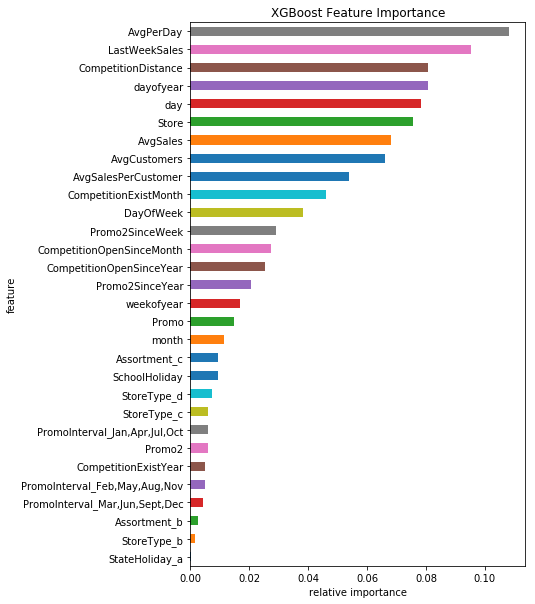

In [86]:
# XGB feature importances
print('create feature map to get feature importance')
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb_2.png', bbox_inches='tight', pad_inches=1)
